### Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import pickle

### Load the dataset

In [2]:
calendar = pd.read_csv("../data/calendar.csv")

In [3]:
print("Shape:", calendar.shape)

Shape: (1308890, 4)


### Preprocess the data

In [4]:
calendar = calendar.dropna(subset=["available"])
calendar = calendar[calendar['available'].isin(['t', 'f'])]

In [5]:
calendar["is_booked"] = calendar["available"].apply(lambda x: 0 if x == "t" else 1)

In [6]:
calendar["price"] = calendar["price"].replace(r'[\$,]', '', regex=True).astype(float)
calendar["median_price"] = calendar.groupby("listing_id")["price"].transform("median")
calendar["price_imputed"] = calendar["price"].fillna(calendar["median_price"])
calendar["price_imputed"] = calendar["price_imputed"].fillna(calendar["price"].median())

In [7]:
calendar["date"] = pd.to_datetime(calendar["date"])
calendar["day"] = calendar["date"].dt.day
calendar["weekday"] = calendar["date"].dt.weekday
calendar["month"] = calendar["date"].dt.month
calendar["weekend"] = calendar["weekday"].isin([5, 6]).astype(int)

### Model training

In [8]:
X = calendar[["price_imputed", "day", "weekday", "weekend","month"]]
y = calendar["is_booked"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression: 
Accuracy = 0.5348
Confusion Matrix: 
 [[54315 74484]
 [47303 85676]]

Decision Tree: 
Accuracy = 0.7247
Confusion Matrix: 
 [[105811  22988]
 [ 49069  83910]]

Random Forest: 
Accuracy = 0.7115
Confusion Matrix: 
 [[101640  27159]
 [ 48373  84606]]

Gradient Boosting: 
Accuracy = 0.7169
Confusion Matrix: 
 [[114074  14725]
 [ 59391  73588]]



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: 
Accuracy = 0.7287
Confusion Matrix: 
 [[109031  19768]
 [ 51244  81735]]


Model Performance Summary
Model                       Accuracy
----------------------------------------
Logistic Regression           0.5348
Decision Tree                 0.7247
Random Forest                 0.7115
Gradient Boosting             0.7169
XGBoost                       0.7287


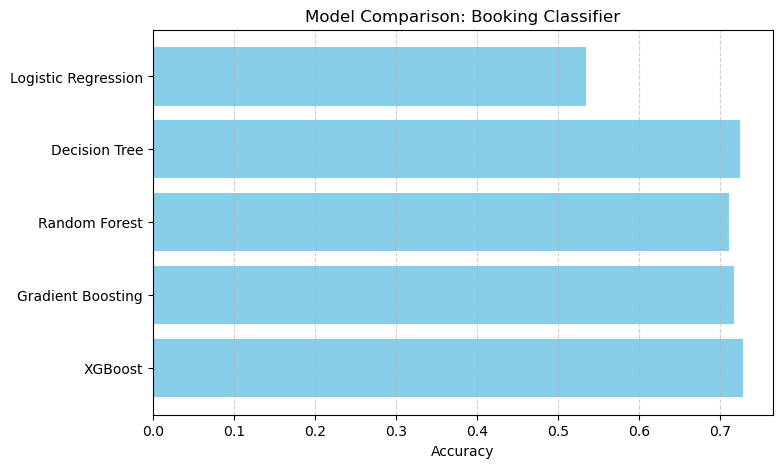

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost":  XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: \nAccuracy = {acc:.4f}")
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print()

print("\nModel Performance Summary")
print(f"{'Model':<25} {'Accuracy':>10}")
print("-" * 40)
for name, acc in results.items():
    print(f"{name:<25} {acc:>10.4f}")


plt.figure(figsize=(8, 5))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison: Booking Classifier")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

The performance of the models good indicating:
- price_imputed is informative which likely correlates with booking rates.
- Time-based signals (weekday, weekend, month, day) add cyclic and seasonal context.
- However, the current features lack sequence history — i.e., what happened in the previous days for a listing

### Re-engineering to improve the performance:

In [11]:
calendar.sort_values(by=["listing_id", "date"], inplace=True)
calendar["listing_freq"] = calendar["listing_id"].map(calendar["listing_id"].value_counts())

calendar["day_sin"] = np.sin(2 * np.pi * calendar["day"] / 31)
calendar["day_cos"] = np.cos(2 * np.pi * calendar["day"] / 31)
calendar["month_sin"] = np.sin(2 * np.pi * calendar["month"] / 12)
calendar["month_cos"] = np.cos(2 * np.pi * calendar["month"] / 12)

In [12]:
split_idx = int(len(calendar) * 0.8)
train_df = calendar.iloc[:split_idx].copy()
test_df = calendar.iloc[split_idx:].copy()

for df in [train_df, test_df]:
    df["prev_booked"] = df.groupby("listing_id")["is_booked"].shift(1).fillna(0)
    df["prev2_booked"] = df.groupby("listing_id")["is_booked"].shift(2).fillna(0)
    df["rolling_7d"] = df.groupby("listing_id")["is_booked"]\
                         .transform(lambda x: x.shift(1).rolling(7, 1).mean())\
                         .fillna(0)

final_features = [
    "price_imputed", "weekday", "weekend", "listing_freq",
    "prev_booked", "prev2_booked", "rolling_7d",
    "day_sin", "day_cos", "month_sin", "month_cos"
]

X_train = train_df[final_features]
y_train = train_df["is_booked"]
X_test = test_df[final_features]
y_test = test_df["is_booked"]

Logistic Regression: 
Accuracy = 0.9807
Confusion Matrix: 
 [[112572   2313]
 [  2733 144160]]

Decision Tree: 
Accuracy = 0.9744
Confusion Matrix: 
 [[111663   3222]
 [  3480 143413]]

Random Forest: 
Accuracy = 0.9781
Confusion Matrix: 
 [[111768   3117]
 [  2629 144264]]

Gradient Boosting: 
Accuracy = 0.9829
Confusion Matrix: 
 [[112466   2419]
 [  2066 144827]]



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:27:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: 
Accuracy = 0.9829
Confusion Matrix: 
 [[112446   2439]
 [  2046 144847]]


Model Performance Summary
Model                       Accuracy
----------------------------------------
Logistic Regression           0.9807
Decision Tree                 0.9744
Random Forest                 0.9781
Gradient Boosting             0.9829
XGBoost                       0.9829


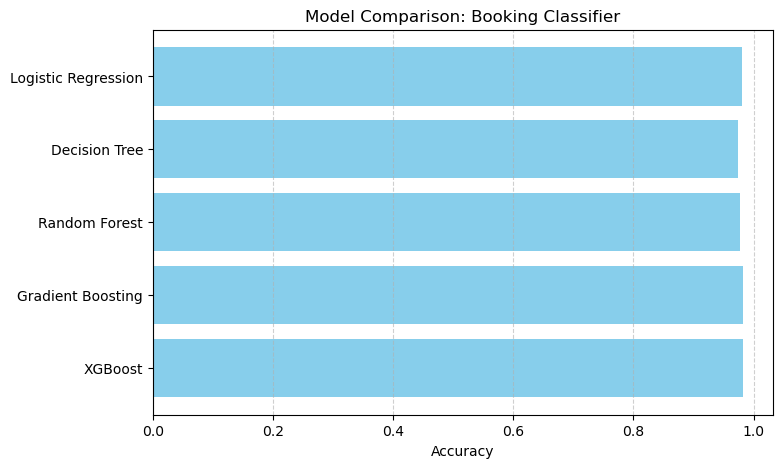

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost":  XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: \nAccuracy = {acc:.4f}")
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print()


print("\nModel Performance Summary")
print(f"{'Model':<25} {'Accuracy':>10}")
print("-" * 40)
for name, acc in results.items():
    print(f"{name:<25} {acc:>10.4f}")


plt.figure(figsize=(8, 5))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison: Booking Classifier")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

A sudden jump of accuracy suggests:

- Overfitting
- Data leakage

In [14]:
for col in final_features:
    if col in train_df.columns:
        corr_val = train_df[[col, "is_booked"]].corr().iloc[0, 1]
        print(f"{col}: {corr_val:.4f}")
    else:
        print(f"{col} not found in train_df")

price_imputed: -0.0779
weekday: 0.0022
weekend: 0.0000
listing_freq: 0.0151
prev_booked: 0.9623
prev2_booked: 0.9345
rolling_7d: 0.9461
day_sin: 0.0042
day_cos: -0.0179
month_sin: -0.0803
month_cos: -0.0334


These values confirm a major sign of hidden overfitting and target leakage. Hence we can do the following:
- Consider safe features
- Re-engineer the leakage-prone features

In [15]:
safe_features = [
    "price_imputed", "weekday", "weekend", "listing_freq",
    "day_sin", "day_cos", "month_sin", "month_cos"
]
X = calendar[safe_features]
y = calendar["is_booked"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression: 
Accuracy = 0.5490
Confusion Matrix: 
 [[63430 65026]
 [53045 80277]]

Decision Tree: 
Accuracy = 0.7241
Confusion Matrix: 
 [[105534  22922]
 [ 49290  84032]]

Random Forest: 
Accuracy = 0.7074
Confusion Matrix: 
 [[100760  27696]
 [ 48910  84412]]

Gradient Boosting: 
Accuracy = 0.7111
Confusion Matrix: 
 [[115361  13095]
 [ 62522  70800]]



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:29:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: 
Accuracy = 0.7299
Confusion Matrix: 
 [[109412  19044]
 [ 51653  81669]]


Model Performance Summary
Model                       Accuracy
----------------------------------------
Logistic Regression           0.5490
Decision Tree                 0.7241
Random Forest                 0.7074
Gradient Boosting             0.7111
XGBoost                       0.7299


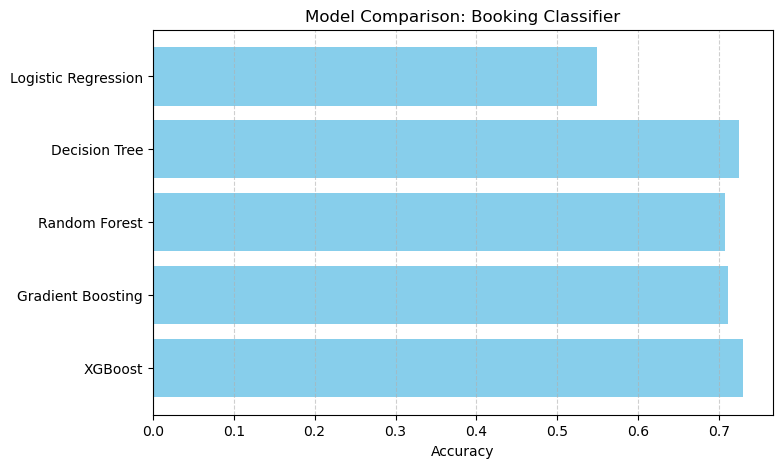

In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost":  XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: \nAccuracy = {acc:.4f}")
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print()

print("\nModel Performance Summary")
print(f"{'Model':<25} {'Accuracy':>10}")
print("-" * 40)
for name, acc in results.items():
    print(f"{name:<25} {acc:>10.4f}")


plt.figure(figsize=(8, 5))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison: Booking Classifier")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Insights:

- Some model performance has improved
- While some of them have slightly reduced due to the complexity introduced with new safe features.

### Feature Importance

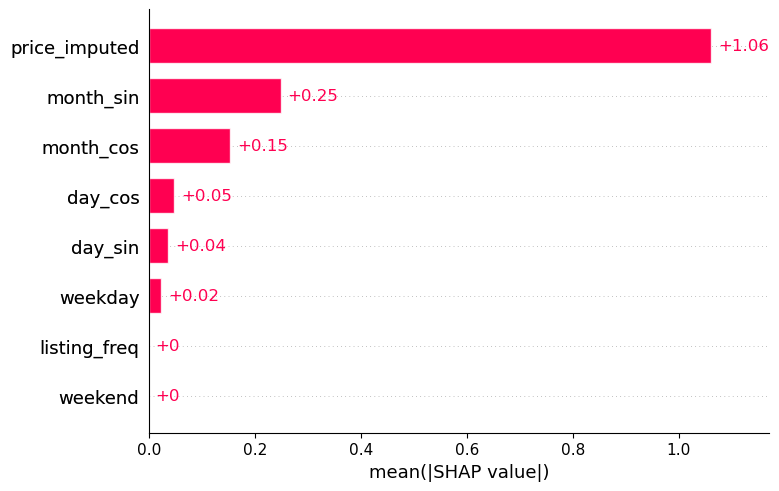

In [18]:
X_sample = X_test.sample(n=1000, random_state=42)

explainer = shap.Explainer(model, X_sample)

shap_values = explainer(X_sample)

shap.plots.bar(shap_values)

Insights:

- The model is heavily reliant on price, with minor adjustments based on monthly trends.
- SHAP confirms the model is simple and interpretable — but could benefit from richer features

### Save the dataset and the model

In [19]:
calendar.to_csv("../outputs/booking_prediction_model_dataset.csv", index=False)
print("Saved dataset as booking_prediction_model_dataset.csv")

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

with open("../models/booking_prediction_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Saved model as booking_prediction_model.pkl")

Saved dataset as booking_prediction_model_dataset.csv
Saved model as booking_prediction_model.pkl
